# Sensitivity Analysis Orchestration

Runs sensitivity analyses on the t-copula pricing model:
1. Impact of k (1st to 5th-to-default)
2. Correlation level (high vs low, with matched marginals)
3. Degrees of freedom
4. Recovery rate

In [1]:
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Configuration

In [2]:
# Notebook to run
PRICING_NOTEBOOK = 'cds_pricing.ipynb'

# Output directories
OUTPUT_DIR = Path('output/runs/sensitivity')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

FIGS_DIR = Path('output/figs_for_report')
TABLES_DIR = Path('output/tables_for_report')
FIGS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Base parameters (from main pricing analysis)
BASE_PARAMS = {
    'DATA_MODE': 'real',
    'SPREAD_MEASURE': 'delta',
    'K': 5,
    'RNG_METHOD': 'sobol',
    'N_SIMS': 100_000,
    'COPULA': 't',
    'CORR_LEVEL': 'high',
    'FIG_OUTPUT_DIR': 'discard_figs',  # Don't overwrite report figures
}

TERM = 5.0

print(f"Base parameters: {BASE_PARAMS}")

Base parameters: {'DATA_MODE': 'real', 'SPREAD_MEASURE': 'delta', 'K': 5, 'RNG_METHOD': 'sobol', 'N_SIMS': 100000, 'COPULA': 't', 'CORR_LEVEL': 'high', 'FIG_OUTPUT_DIR': 'discard_figs'}


In [3]:
# Ensure discard_figs directory exists
Path('output/discard_figs').mkdir(parents=True, exist_ok=True)

In [4]:
def run_pricing(params, output_name):
    """Run pricing notebook with given parameters and return results."""
    output_path = OUTPUT_DIR / f'{output_name}.ipynb'
    
    print(f"Running: {output_name}")
    try:
        pm.execute_notebook(
            PRICING_NOTEBOOK,
            output_path,
            parameters=params,
            kernel_name='python3'
        )
        
        # Read results
        nb = sb.read_notebook(str(output_path))
        scraps = nb.scraps
        
        result = {
            'fair_spread_bps': scraps['fair_spread'].data,
            'se_bps': scraps['se_bps'].data,
            'n_defaults_in_term': scraps['n_defaults_in_term'].data if 'n_defaults_in_term' in scraps else None,
        }
        
        # Get default times if available
        if 'kth_default_times' in scraps:
            result['kth_default_times'] = np.array(scraps['kth_default_times'].data, dtype=float)
        
        print(f"  -> Spread: {result['fair_spread_bps']:.2f} bps (SE: {result['se_bps']:.2f})")
        return result
    
    except Exception as e:
        print(f"  -> Failed: {e}")
        return None

---
## 1. Sensitivity to k (Tranche Seniority)

In [5]:
# Run for k = 1 to 5
k_values = [1, 2, 3, 4, 5]
k_results = []

for k in k_values:
    params = {**BASE_PARAMS, 'K': k}
    result = run_pricing(params, f'sens_k_{k}')
    if result:
        result['K'] = k
        k_results.append(result)

k_df = pd.DataFrame(k_results)
print("\nResults:")
display(k_df[['K', 'fair_spread_bps', 'se_bps']])

Running: sens_k_1


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 283.64 bps (SE: 1.98)
Running: sens_k_2


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 180.63 bps (SE: 1.54)
Running: sens_k_3


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 127.78 bps (SE: 1.28)
Running: sens_k_4


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 89.48 bps (SE: 1.06)
Running: sens_k_5


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 53.84 bps (SE: 0.81)

Results:


,K,fair_spread_bps,se_bps
0,1,283.640096,1.981944
1,2,180.626759,1.543042
2,3,127.777288,1.280383
3,4,89.482983,1.059367
4,5,53.842125,0.812736


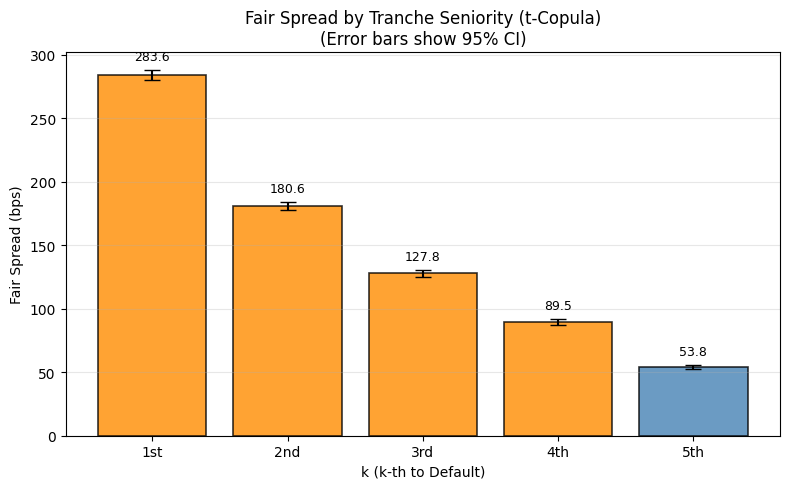

In [6]:
# Chart: Fair spread by k with confidence intervals
fig, ax = plt.subplots(figsize=(8, 5))

k_vals = k_df['K'].values
spreads = k_df['fair_spread_bps'].values
errors = 1.96 * k_df['se_bps'].values

# Color base case (K=5) differently
colors = ['darkorange' if k != 5 else 'steelblue' for k in k_vals]

bars = ax.bar(k_vals, spreads, yerr=errors, capsize=6,
              color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)

# Add value labels
for k, spread, err in zip(k_vals, spreads, errors):
    ax.text(k, spread + err + max(spreads)*0.02, f'{spread:.1f}',
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel('k (k-th to Default)')
ax.set_ylabel('Fair Spread (bps)')
ax.set_title('Fair Spread by Tranche Seniority (t-Copula)\n(Error bars show 95% CI)')
ax.set_xticks(k_vals)
ax.set_xticklabels([f'{k}' + ('st' if k==1 else 'nd' if k==2 else 'rd' if k==3 else 'th') for k in k_vals])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'sensitivity_k.png', dpi=150)
plt.show()

# Save data
k_df.to_csv(TABLES_DIR / 'sensitivity_k.csv', index=False)

---
## 2. Sensitivity to Correlation Level

In [7]:
# Run for high and low correlation
corr_levels = ['high', 'low']
corr_results = {}

for corr in corr_levels:
    params = {**BASE_PARAMS, 'CORR_LEVEL': corr}
    result = run_pricing(params, f'sens_corr_{corr}')
    if result:
        result['corr_level'] = corr
        corr_results[corr] = result

corr_df = pd.DataFrame(corr_results.values())
print("\nResults:")
display(corr_df[['corr_level', 'fair_spread_bps', 'se_bps', 'n_defaults_in_term']])

Running: sens_corr_high


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 53.84 bps (SE: 0.81)
Running: sens_corr_low


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 1.13 bps (SE: 0.12)

Results:


,corr_level,fair_spread_bps,se_bps,n_defaults_in_term
0,high,53.842125,0.812736,4388
1,low,1.128366,0.116365,94


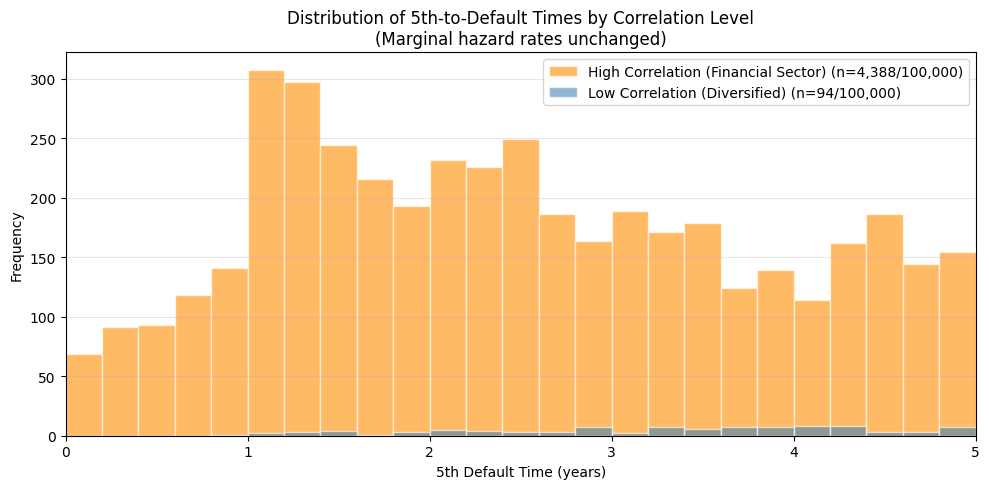

In [8]:
# Chart 1: Distribution of default times by correlation level
fig, ax = plt.subplots(figsize=(10, 5))

colors = {'high': 'darkorange', 'low': 'steelblue'}
labels = {'high': 'High Correlation (Financial Sector)', 'low': 'Low Correlation (Diversified)'}

# Shared bins up to TERM
bins = np.linspace(0, TERM, 26)

# Plot high first (behind), then low (in front)
for corr in ['high', 'low']:
    if corr in corr_results and 'kth_default_times' in corr_results[corr]:
        times = np.array(corr_results[corr]['kth_default_times'])
        times_in_term = times[times <= TERM]
        n_total = len(times)
        n_in_term = len(times_in_term)
        
        ax.hist(times_in_term, bins=bins, alpha=0.6,
                label=f"{labels[corr]} (n={n_in_term:,}/{n_total:,})",
                color=colors[corr], edgecolor='white')

ax.set_xlabel('5th Default Time (years)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of 5th-to-Default Times by Correlation Level\n(Marginal hazard rates unchanged)')
ax.set_xlim(0, TERM)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGS_DIR / 'sensitivity_correlation_times.png', dpi=150)
plt.show()

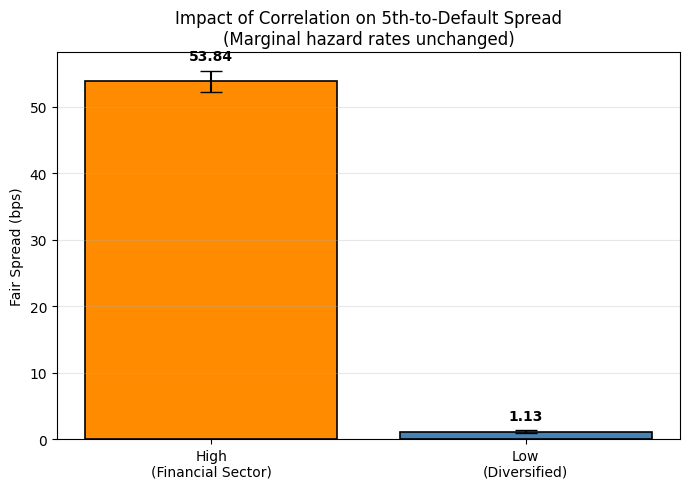

In [9]:
# Chart 2: Spread comparison by correlation level
fig, ax = plt.subplots(figsize=(7, 5))

corr_labels = ['High\n(Financial Sector)', 'Low\n(Diversified)']
spreads = [corr_results['high']['fair_spread_bps'], corr_results['low']['fair_spread_bps']]
errors = [1.96 * corr_results['high']['se_bps'], 1.96 * corr_results['low']['se_bps']]

x_pos = np.arange(len(corr_labels))
bars = ax.bar(x_pos, spreads, yerr=errors, capsize=8,
              color=['darkorange', 'steelblue'], edgecolor='black', linewidth=1.2)

# Add value labels
for i, (spread, err) in enumerate(zip(spreads, errors)):
    ax.text(i, spread + err + max(spreads)*0.02, f'{spread:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(corr_labels)
ax.set_ylabel('Fair Spread (bps)')
ax.set_title('Impact of Correlation on 5th-to-Default Spread\n(Marginal hazard rates unchanged)')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'sensitivity_correlation_spread.png', dpi=150)
plt.show()

# Save data
corr_df.to_csv(TABLES_DIR / 'sensitivity_correlation.csv', index=False)

---
## 3. Sensitivity to Degrees of Freedom

In [10]:
# Run for various df values
# Note: 3.9 is the MLE-estimated base case

df_values = [3, 3.9, 6, 10, 15, 30]
df_results = []

for df in df_values:
    params = {**BASE_PARAMS, 'DF_OVERRIDE': df}
    result = run_pricing(params, f'sens_df_{df}')
    if result:
        result['df'] = df
        df_results.append(result)

# Also get Gaussian result for comparison
params_gaussian = {**BASE_PARAMS, 'COPULA': 'gaussian'}
gaussian_result = run_pricing(params_gaussian, 'sens_df_gaussian')

df_df = pd.DataFrame(df_results)
print("\nResults:")
display(df_df[['df', 'fair_spread_bps', 'se_bps']])
print(f"\nGaussian (df->inf): {gaussian_result['fair_spread_bps']:.2f} bps")

Running: sens_df_3


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 60.29 bps (SE: 0.86)
Running: sens_df_3.9


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 54.33 bps (SE: 0.82)
Running: sens_df_6


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 43.44 bps (SE: 0.73)
Running: sens_df_10


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 34.03 bps (SE: 0.64)
Running: sens_df_15


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 28.45 bps (SE: 0.59)
Running: sens_df_30


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 21.17 bps (SE: 0.51)
Running: sens_df_gaussian


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 7.36 bps (SE: 0.30)

Results:


,df,fair_spread_bps,se_bps
0,3.0,60.291613,0.861588
1,3.9,54.328291,0.816404
2,6.0,43.441268,0.728346
3,10.0,34.027204,0.642760
4,15.0,28.450974,0.586643
5,30.0,21.165605,0.505032



Gaussian (df->inf): 7.36 bps


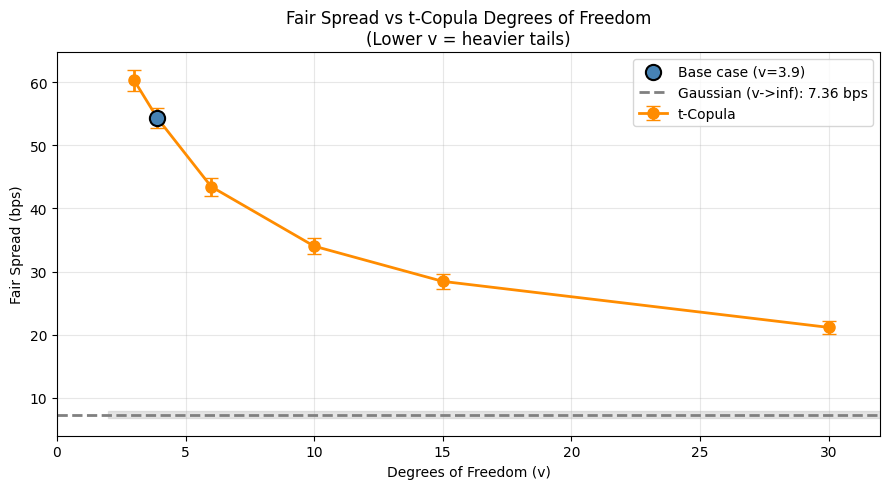

In [11]:
# Chart: Fair spread vs degrees of freedom
fig, ax = plt.subplots(figsize=(9, 5))

df_vals = df_df['df'].values
spreads = df_df['fair_spread_bps'].values
errors = 1.96 * df_df['se_bps'].values

# Identify base case (df=3.9)
base_idx = np.argmin(np.abs(df_vals - 3.9))

# Plot t-copula results - line connecting all points
ax.errorbar(df_vals, spreads, yerr=errors, fmt='o-', color='darkorange',
            linewidth=2, markersize=8, capsize=5, label='t-Copula')

# Highlight base case with different color
ax.scatter([df_vals[base_idx]], [spreads[base_idx]], color='steelblue', 
           s=120, zorder=5, edgecolor='black', linewidth=1.5, label=f'Base case (v={df_vals[base_idx]:.1f})')

# Add Gaussian reference line
if gaussian_result:
    ax.axhline(gaussian_result['fair_spread_bps'], color='gray', linestyle='--',
               linewidth=2, label=f"Gaussian (v->inf): {gaussian_result['fair_spread_bps']:.2f} bps")
    ax.fill_between([min(df_vals)-1, max(df_vals)+5],
                    gaussian_result['fair_spread_bps'] - 1.96*gaussian_result['se_bps'],
                    gaussian_result['fair_spread_bps'] + 1.96*gaussian_result['se_bps'],
                    color='gray', alpha=0.2)

ax.set_xlabel('Degrees of Freedom (v)')
ax.set_ylabel('Fair Spread (bps)')
ax.set_title('Fair Spread vs t-Copula Degrees of Freedom\n(Lower v = heavier tails)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max(df_vals) + 2)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'sensitivity_df.png', dpi=150)
plt.show()

# Save data
df_df.to_csv(TABLES_DIR / 'sensitivity_df.csv', index=False)

---
## 4. Sensitivity to Recovery Rate

In [12]:
# Run for various recovery rates
recovery_rates = [0.0, 0.30, 0.40, 0.50]
recovery_results = []

for R in recovery_rates:
    params = {**BASE_PARAMS, 'RECOVERY_RATE': R}
    result = run_pricing(params, f'sens_recovery_{int(R*100)}')
    if result:
        result['recovery_rate'] = R
        recovery_results.append(result)

recovery_df = pd.DataFrame(recovery_results)
print("\nResults:")
display(recovery_df[['recovery_rate', 'fair_spread_bps', 'se_bps']])

Running: sens_recovery_0


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 65.16 bps (SE: 1.15)
Running: sens_recovery_30


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 56.59 bps (SE: 0.90)
Running: sens_recovery_40


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 53.84 bps (SE: 0.81)
Running: sens_recovery_50


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

  -> Spread: 49.35 bps (SE: 0.71)

Results:


,recovery_rate,fair_spread_bps,se_bps
0,0.0,65.162456,1.149601
1,0.3,56.588905,0.898892
2,0.4,53.842125,0.812736
3,0.5,49.348478,0.711845


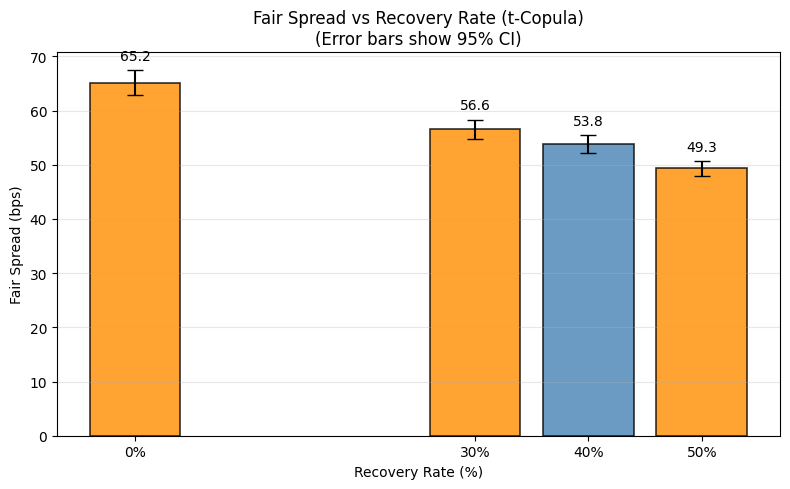

In [13]:
# Chart: Fair spread vs recovery rate
fig, ax = plt.subplots(figsize=(8, 5))

R_vals = recovery_df['recovery_rate'].values * 100  # Convert to %
spreads = recovery_df['fair_spread_bps'].values
errors = 1.96 * recovery_df['se_bps'].values

# Color base case (R=40%) differently
colors = ['darkorange' if r != 40 else 'steelblue' for r in R_vals]

bars = ax.bar(R_vals, spreads, yerr=errors, capsize=6, width=8,
              color=colors, edgecolor='black', linewidth=1.2, alpha=0.8)

# Add value labels
for r, spread, err in zip(R_vals, spreads, errors):
    ax.text(r, spread + err + max(spreads)*0.02, f'{spread:.1f}',
            ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Recovery Rate (%)')
ax.set_ylabel('Fair Spread (bps)')
ax.set_title('Fair Spread vs Recovery Rate (t-Copula)\n(Error bars show 95% CI)')
ax.set_xticks(R_vals)
ax.set_xticklabels([f'{int(r)}%' for r in R_vals])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'sensitivity_recovery.png', dpi=150)
plt.show()

# Save data
recovery_df.to_csv(TABLES_DIR / 'sensitivity_recovery.csv', index=False)

---
## Summary

In [14]:
print("="*60)
print("SENSITIVITY ANALYSIS SUMMARY")
print("="*60)
print(f"\nBase case: t-copula, K=5, high correlation, R=40%")
print(f"Simulations: {BASE_PARAMS['N_SIMS']:,}, RNG: {BASE_PARAMS['RNG_METHOD']}")

print("\n1. IMPACT OF k:")
for _, row in k_df.iterrows():
    print(f"   k={int(row['K'])}: {row['fair_spread_bps']:.2f} bps")

print("\n2. CORRELATION LEVEL:")
for _, row in corr_df.iterrows():
    print(f"   {row['corr_level']}: {row['fair_spread_bps']:.2f} bps")

print("\n3. DEGREES OF FREEDOM:")
for _, row in df_df.iterrows():
    print(f"   v={row['df']}: {row['fair_spread_bps']:.2f} bps")
if gaussian_result:
    print(f"   Gaussian: {gaussian_result['fair_spread_bps']:.2f} bps")

print("\n4. RECOVERY RATE:")
for _, row in recovery_df.iterrows():
    print(f"   R={row['recovery_rate']:.0%}: {row['fair_spread_bps']:.2f} bps")

SENSITIVITY ANALYSIS SUMMARY

Base case: t-copula, K=5, high correlation, R=40%
Simulations: 100,000, RNG: sobol

1. IMPACT OF k:
   k=1: 283.64 bps
   k=2: 180.63 bps
   k=3: 127.78 bps
   k=4: 89.48 bps
   k=5: 53.84 bps

2. CORRELATION LEVEL:
   high: 53.84 bps
   low: 1.13 bps

3. DEGREES OF FREEDOM:
   v=3.0: 60.29 bps
   v=3.9: 54.33 bps
   v=6.0: 43.44 bps
   v=10.0: 34.03 bps
   v=15.0: 28.45 bps
   v=30.0: 21.17 bps
   Gaussian: 7.36 bps

4. RECOVERY RATE:
   R=0%: 65.16 bps
   R=30%: 56.59 bps
   R=40%: 53.84 bps
   R=50%: 49.35 bps
